In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
import umap
import os
import seaborn as sns

# Plot Learning Curves



In [34]:
se_path = 'sv_results/v4/all_metrics.csv'

df = pd.read_csv(se_path)


df = df[df['run_type'] != 'single_moon']


print(df['run_type'].unique())

df['run_type'] = df['run_type'].replace({'dp_fl_sens18.0_eps100.0': 'DP-FL Eps=100', 
'dp_fl_sens18.0_eps500.0': 'DP-FL Eps=500', 'dp_fl_sens18.0_eps5000' : 'DP-FL Eps=5000', 'dp_fl_sens18.0_eps1000.0': 'DP-FL Eps=1000',
'fl_run': 'Baseline Fl'
})
df['episode_id'] = df.groupby('metric').cumcount()

df_pivoted = df.pivot(
    index=['round','step', 'run_type', 'client_id', 'episode_id'], 
    columns='metric', 
    values='value'
).reset_index()

df_pivoted.columns.name = None
df_pivoted.head()


df_pivoted.to_csv('sv_results/v4/all_metrics_pivoted.csv', index=False)

['dp_fl_sens18.0_eps100.0' 'dp_fl_sens18.0_eps500.0'
 'dp_fl_sens18.0_eps5000' 'dp_fl_sens18.0_eps1000.0' 'fl_run']


### ROUND

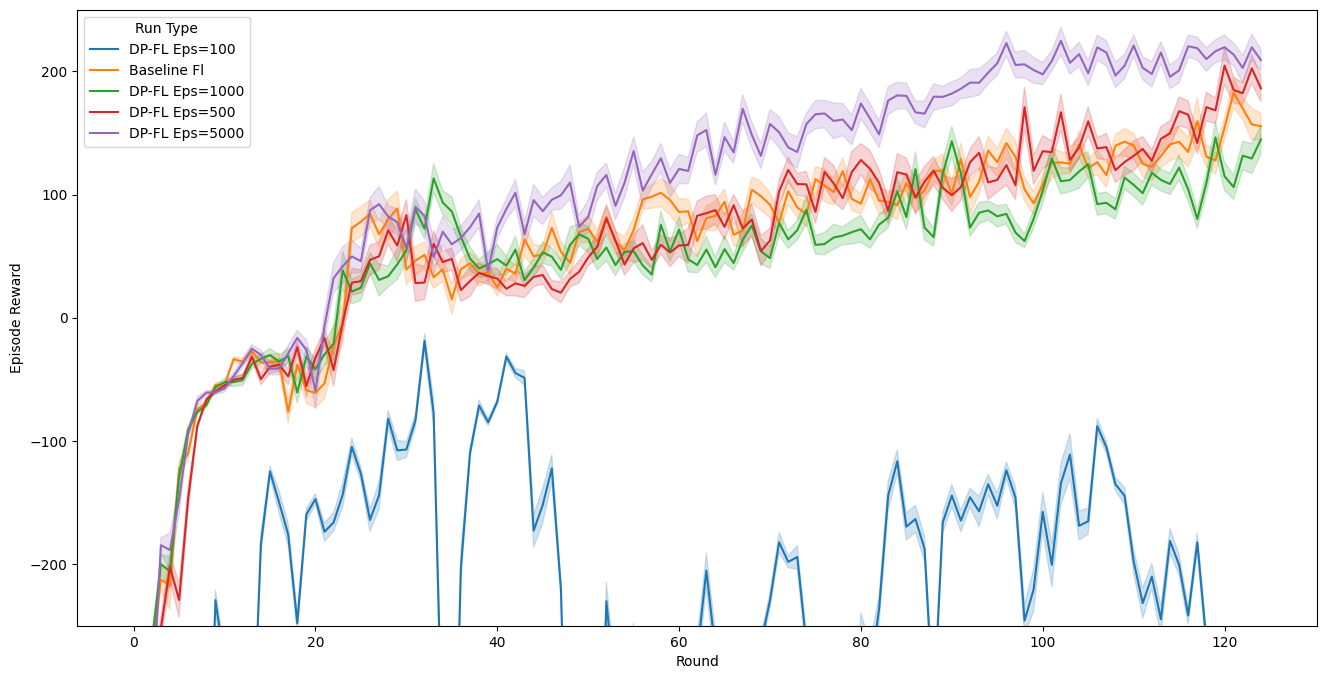

In [35]:


OUTPUT_DIR = "figures"
# Ensure the directory exists BEFORE trying to save
os.makedirs(OUTPUT_DIR, exist_ok=True) 

plt.figure(figsize=(16, 8))
sns.lineplot(data=df_pivoted, x="round", y="episode_reward", hue="run_type")

plt.xlabel("Round")
plt.ylabel("Episode Reward")
plt.ylim(-250, 250)
plt.legend(title="Run Type")

# --- FIX START ---
# 1. Define the path
filename = "round_learning_curve.pdf"
out_path = os.path.join(OUTPUT_DIR, filename)

# 2. Save the figure FIRST (while the canvas still has data)
plt.savefig(out_path, dpi=150, bbox_inches='tight') 

# 3. Show the figure LAST (this will clear the canvas)
plt.show()



### Step

In [ ]:

OUTPUT_DIR = "figures"
# Ensure the directory exists BEFORE trying to save
os.makedirs(OUTPUT_DIR, exist_ok=True) 

plt.figure(figsize=(16, 8))
sns.lineplot(data=df_pivoted, x="episo", y="episode_reward", hue="run_type")

plt.xlabel("Round")
plt.ylabel("Episode Reward")
plt.ylim(-250, 250)
plt.legend(title="Run Type")

# --- FIX START ---
# 1. Define the path
filename = "round_learning_curve.pdf"
out_path = os.path.join(OUTPUT_DIR, filename)

# 2. Save the figure FIRST (while the canvas still has data)
plt.savefig(out_path, dpi=150, bbox_inches='tight') 

# 3. Show the figure LAST (this will clear the canvas)
plt.show()

In [ ]:
df_pivoted.loc[df_pivoted['client_id'].str.contains('Earth', case=False, na=False), 'Category'] = 'Earth'
df_pivoted.loc[df_pivoted['client_id'].str.contains('Mars', case=False, na=False), 'Category'] = 'Mars'
df_pivoted.loc[df_pivoted['client_id'].str.contains('Moon', case=False, na=False), 'Category'] = 'Moon'
df_pivoted.head()

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pivoted, x="round", y="episode_reward", hue="run_type",style="Category")

In [49]:
import gymnasium as gym
from stable_baselines3 import PPO, DQN, A2C
import os
import numpy as np
import pandas as pd

# --- CONFIGURATION ---

# 1. MODELS: Dictionary of { "Name": "Path" }
# You can add as many as you want here.
MODELS = {
    "Single Moon": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/single_moon/single_Client_1_Moon_model_final.zip",
    "Single Earth": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/single_moon/single_Client_2_Earth_model_final.zip",
    "Single Mars": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/single_moon/single_Client_3_Mars_model_final.zip",
    "Baseline FL": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/fl_run/global_fl_model_final.zip",
    "Model EPS=100": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/dp_fl_sens18.0_eps100.0/global_model_final.zip",
    "Model EPS=500": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/dp_fl_sens18.0_eps500.0/global_model_final.zip",
    "Model EPS=1000": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/dp_fl_sens18.0_eps1000.0/global_model_final.zip",
    "Model EPS=5000": "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/dp_fl_sens18.0_eps5000/global_model_final.zip",
    # "New_Model": "path/to/new_model.zip"
}

# 2. ALGORITHM: Ensure all models above use this algorithm (or add logic to switch)
AlgorithmClass = PPO 

# 3. SETTINGS
N_EVAL_EPISODES = 50

# 4. SCENARIOS: The environments to test against
SCENARIOS = [
    {"name": "Earth - No Wind",       "gravity": -9.8, "enable_wind": False, "wind_power": 0.0},
    {"name": "Mars - Wind=5",    "gravity": -3.73,  "enable_wind": True, "wind_power": 5.0},
    {"name": "Moon - Wind=15",      "gravity": -1.62, "enable_wind": True,  "wind_power": 15.0},
    {"name": "Earth - Wind=6",       "gravity": -9.8, "enable_wind": True, "wind_power": 6.0},
    {"name": "Mars - Wind=8",    "gravity": -3.73,  "enable_wind": True, "wind_power": 8.0},
    {"name": "Moon - Wind=7",      "gravity": -1.62, "enable_wind": True,  "wind_power": 7.0},
    {"name": "Turbulence",     "gravity": -10.0, "enable_wind": True,  "wind_power": 10.0, "turbulence_power": 1.5},
]
# ---------------------

results_data = []

print(f"Starting evaluation of {len(MODELS)} models across {len(SCENARIOS)} scenarios...")
print("-" * 60)

for model_name, model_path in MODELS.items():
    
    # 1. Check file existence
    if not os.path.exists(model_path):
        print(f"!! WARNING: Skipping '{model_name}'. File not found: {model_path}")
        continue
        
    try:
        print(f">> Loading {model_name}...")
        model = AlgorithmClass.load(model_path)
        
        # 2. Iterate through Scenarios
        for scenario_config in SCENARIOS:
            # Create a copy so we don't modify the original config for the next model
            config = scenario_config.copy()
            scenario_name = config.pop("name")
            
            # Create environment (No rendering for speed)
            env = gym.make("LunarLander-v3", render_mode=None, **config)
            
            episode_rewards = []
            
            # 3. Run Episodes
            for _ in range(N_EVAL_EPISODES):
                obs, _ = env.reset()
                done = False
                truncated = False
                total_reward = 0
                
                while not (done or truncated):
                    action, _ = model.predict(obs, deterministic=True)
                    obs, reward, done, truncated, _ = env.step(action)
                    total_reward += reward
                
                episode_rewards.append(total_reward)
            
            # 4. Aggregate Stats
            mean_reward = np.mean(episode_rewards)
            std_reward = np.std(episode_rewards)
            
            results_data.append({
                "Model": model_name,
                "Scenario": scenario_name,
                "Mean Reward": mean_reward,
                "Std Dev": std_reward
            })
            
            env.close()
            
    except Exception as e:
        print(f"!! Error evaluating {model_name}: {e}")

# --- DISPLAY TABLES ---

if results_data:
    df = pd.DataFrame(results_data)

    # Formatting settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.float_format', '{:.2f}'.format)

    print("\n" + "="*30)
    print("      FINAL COMPARISON")
    print("="*30)

    # CREATE PIVOT TABLE (Rows = Scenarios, Columns = Models)
    # This is the best way to compare models side-by-side
    pivot_df = df.pivot(index="Scenario", columns="Model", values="Mean Reward")
    
    print("\n--- Average Reward by Model & Scenario ---")
    print(pivot_df)
    pivot_df.to_csv("/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/figures/results.csv")
    print("\n--- Detailed Statistics ---")
    print(df[["Model", "Scenario", "Mean Reward", "Std Dev"]])

else:
    print("\nNo results generated. Check your model paths.")

Starting evaluation of 8 models across 7 scenarios...
------------------------------------------------------------
>> Loading Single Moon...
>> Loading Single Earth...
>> Loading Single Mars...
>> Loading Baseline FL...
>> Loading Model EPS=100...
>> Loading Model EPS=500...
>> Loading Model EPS=1000...
>> Loading Model EPS=5000...

      FINAL COMPARISON

--- Average Reward by Model & Scenario ---
Model            Baseline FL  Model EPS=100  Model EPS=1000  Model EPS=500  Model EPS=5000  Single Earth  Single Mars  Single Moon
Scenario                                                                                                                          
Earth - No Wind       248.73        -349.12          255.18         261.16          270.95        247.16       206.17        28.79
Earth - Wind=6        196.97        -363.20          180.52         200.76          265.18        226.44       130.76       -26.37
Mars - Wind=5         248.60        -647.68          219.30         260.15

--- Calculating Residuals for Standard FL ---
Processing 50 rounds in weights...

--- Calculating Residuals for DP FL ---
Processing 50 rounds in weights...

Running UMAP on residuals (this may take a moment)...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Saved UMAP plot to fl_vs_dp_umap_residuals.png


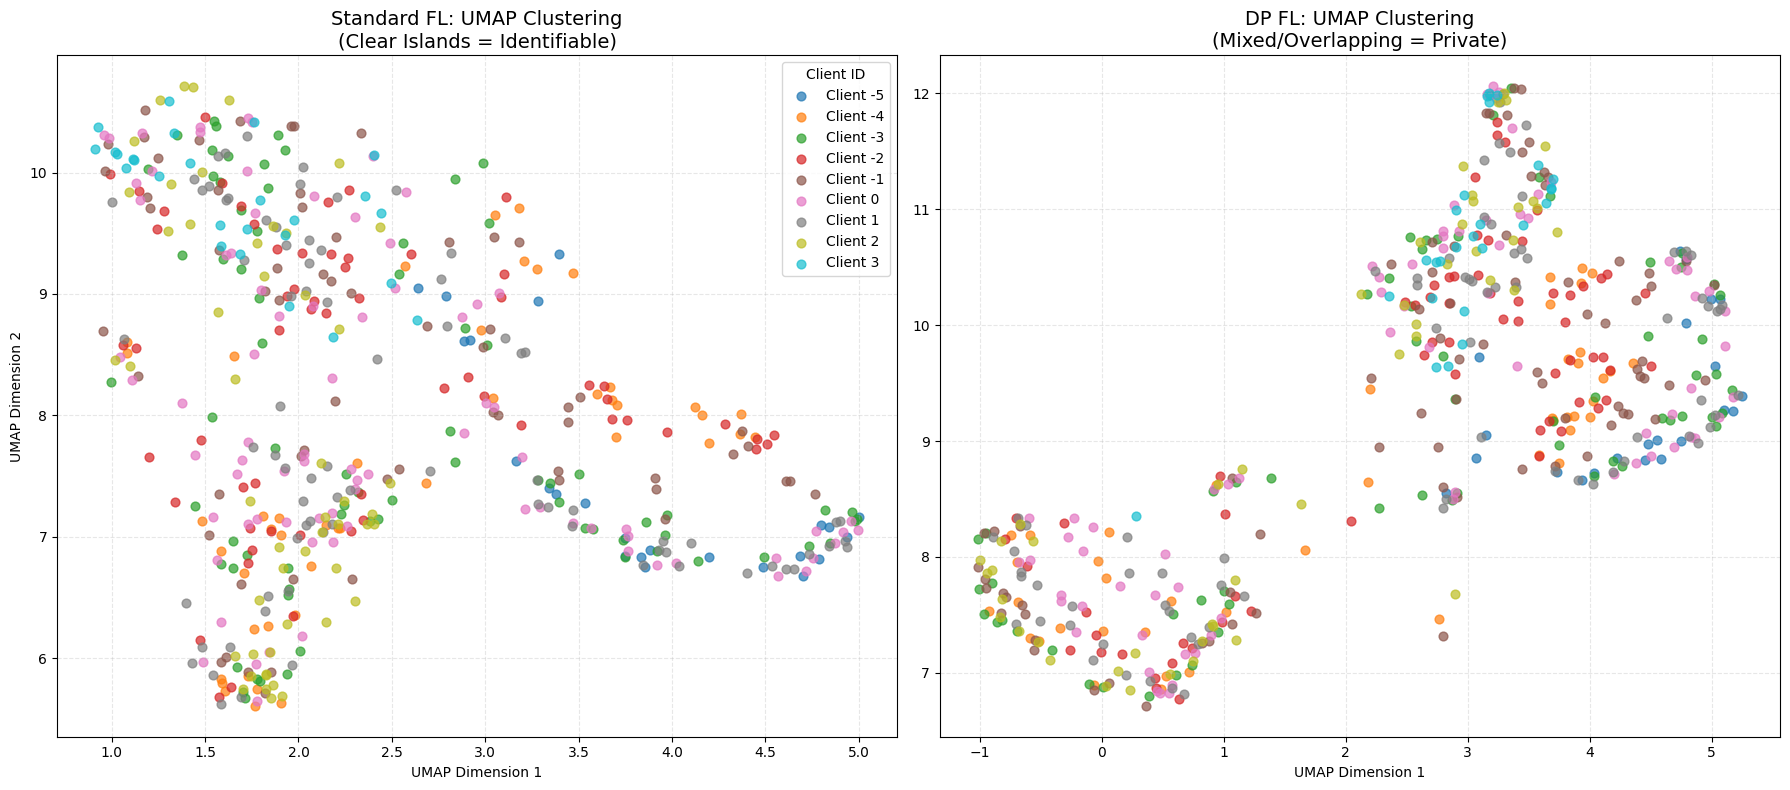

: 

In [ ]:
import torch
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import umap  # Ensure you have installed: pip install umap-learn

# --- CONFIGURATION ---
DP_BASE_PATH = "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/dp_fl_sens18.0_eps1000.0/weights"
FL_BASE_PATH = "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/fl_run/weights"

MAX_ROUNDS_TO_LOAD = 50

# --- UMAP PARAMETERS ---
# n_neighbors: Controls how UMAP balances local vs global structure.
#   - Low (5-15): Focuses on very local detail (good for finding small clusters).
#   - High (20-50): Focuses on the big picture (good for global shape).
UMAP_NEIGHBORS = 50
UMAP_MIN_DIST = 0.1

def get_client_id(filename):
    match = re.search(r'Client_([-\d]+)', filename)
    if match:
        return int(match.group(1))
    return filename

def load_residuals(base_path, max_rounds):
    """
    Loads weights, calculates the ROUND AVERAGE, and subtracts it from each client.
    Returns: Residuals (Client - Average), Client Labels
    """
    residuals = []
    labels = []
    
    round_dirs = glob.glob(os.path.join(base_path, "round_*"))
    round_dirs.sort(key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isdigit() else 0)
    round_dirs = round_dirs[:max_rounds]
    
    print(f"Processing {len(round_dirs)} rounds in {os.path.basename(base_path)}...")

    for r_dir in round_dirs:
        pt_files = glob.glob(os.path.join(r_dir, "*.pt"))
        
        round_vectors = []
        round_ids = []
        
        # 1. Load all clients for this specific round
        for pt_file in pt_files:
            if "Global_Model" in pt_file:
                continue
            
            try:
                state_dict = torch.load(pt_file, map_location='cpu')
                if not isinstance(state_dict, dict) and hasattr(state_dict, 'state_dict'):
                    state_dict = state_dict.state_dict()
                
                # Flatten
                keys = sorted(state_dict.keys())
                flat_vector = np.concatenate([state_dict[k].numpy().flatten() for k in keys if hasattr(state_dict[k], 'numpy')])
                
                round_vectors.append(flat_vector)
                round_ids.append(get_client_id(os.path.basename(pt_file)))
                
            except Exception as e:
                pass 
        
        if not round_vectors:
            continue

        # 2. Calculate Average for this round
        round_matrix = np.array(round_vectors)
        round_mean = np.mean(round_matrix, axis=0)
        
        # 3. Compute Residuals
        diffs = round_matrix - round_mean
        
        residuals.extend(diffs)
        labels.extend(round_ids)

    return np.array(residuals), np.array(labels)

# --- MAIN EXECUTION ---

print("--- Calculating Residuals for Standard FL ---")
X_fl_res, y_fl = load_residuals(FL_BASE_PATH, MAX_ROUNDS_TO_LOAD)

print("\n--- Calculating Residuals for DP FL ---")
X_dp_res, y_dp = load_residuals(DP_BASE_PATH, MAX_ROUNDS_TO_LOAD)

if len(X_fl_res) == 0 or len(X_dp_res) == 0:
    print("Error: Not enough data found.")
    exit()

# 2. RUNNING UMAP
print("\nRunning UMAP on residuals (this may take a moment)...")
combined_residuals = np.vstack([X_fl_res, X_dp_res])

# Initialize UMAP
reducer = umap.UMAP(
    n_neighbors=UMAP_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    n_components=2,
    random_state=42  # Fixed seed for reproducibility
)

combined_embedding = reducer.fit_transform(combined_residuals)

# Split back
X_fl_umap = combined_embedding[:len(X_fl_res)]
X_dp_umap = combined_embedding[len(X_fl_res):]

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Consistent Colors
all_clients = sorted(list(set(y_fl) | set(y_dp)))
colors = plt.cm.tab10(np.linspace(0, 1, len(all_clients)))
id_to_color = {cid: colors[i] for i, cid in enumerate(all_clients)}

# --- Plot 1: Standard FL UMAP ---
for cid in sorted(list(set(y_fl))):
    mask = (y_fl == cid)
    axes[0].scatter(X_fl_umap[mask, 0], X_fl_umap[mask, 1], 
                    color=id_to_color[cid], label=f"Client {cid}", s=40, alpha=0.7)

axes[0].set_title("Standard FL: UMAP Clustering\n(Clear Islands = Identifiable)", fontsize=14)
axes[0].set_xlabel("UMAP Dimension 1")
axes[0].set_ylabel("UMAP Dimension 2")
axes[0].grid(True, linestyle='--', alpha=0.3)
axes[0].legend(title="Client ID")

# --- Plot 2: DP FL UMAP ---
for cid in sorted(list(set(y_dp))):
    mask = (y_dp == cid)
    axes[1].scatter(X_dp_umap[mask, 0], X_dp_umap[mask, 1], 
                    color=id_to_color[cid], label=f"Client {cid}", s=40, alpha=0.7)

axes[1].set_title("DP FL: UMAP Clustering\n(Mixed/Overlapping = Private)", fontsize=14)
axes[1].set_xlabel("UMAP Dimension 1")
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
output_filename = "fl_vs_dp_umap_residuals.png"
plt.savefig(output_filename)
print(f"\nSaved UMAP plot to {output_filename}")
plt.show()

--- Loading Standard FL Data ---
Loading 50 rounds from: weights...

--- Loading DP FL Data ---
Loading 50 rounds from: weights...

Running UMAP on combined trajectory data...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Saved UMAP trajectory plot to fl_vs_dp_umap_rounds.png


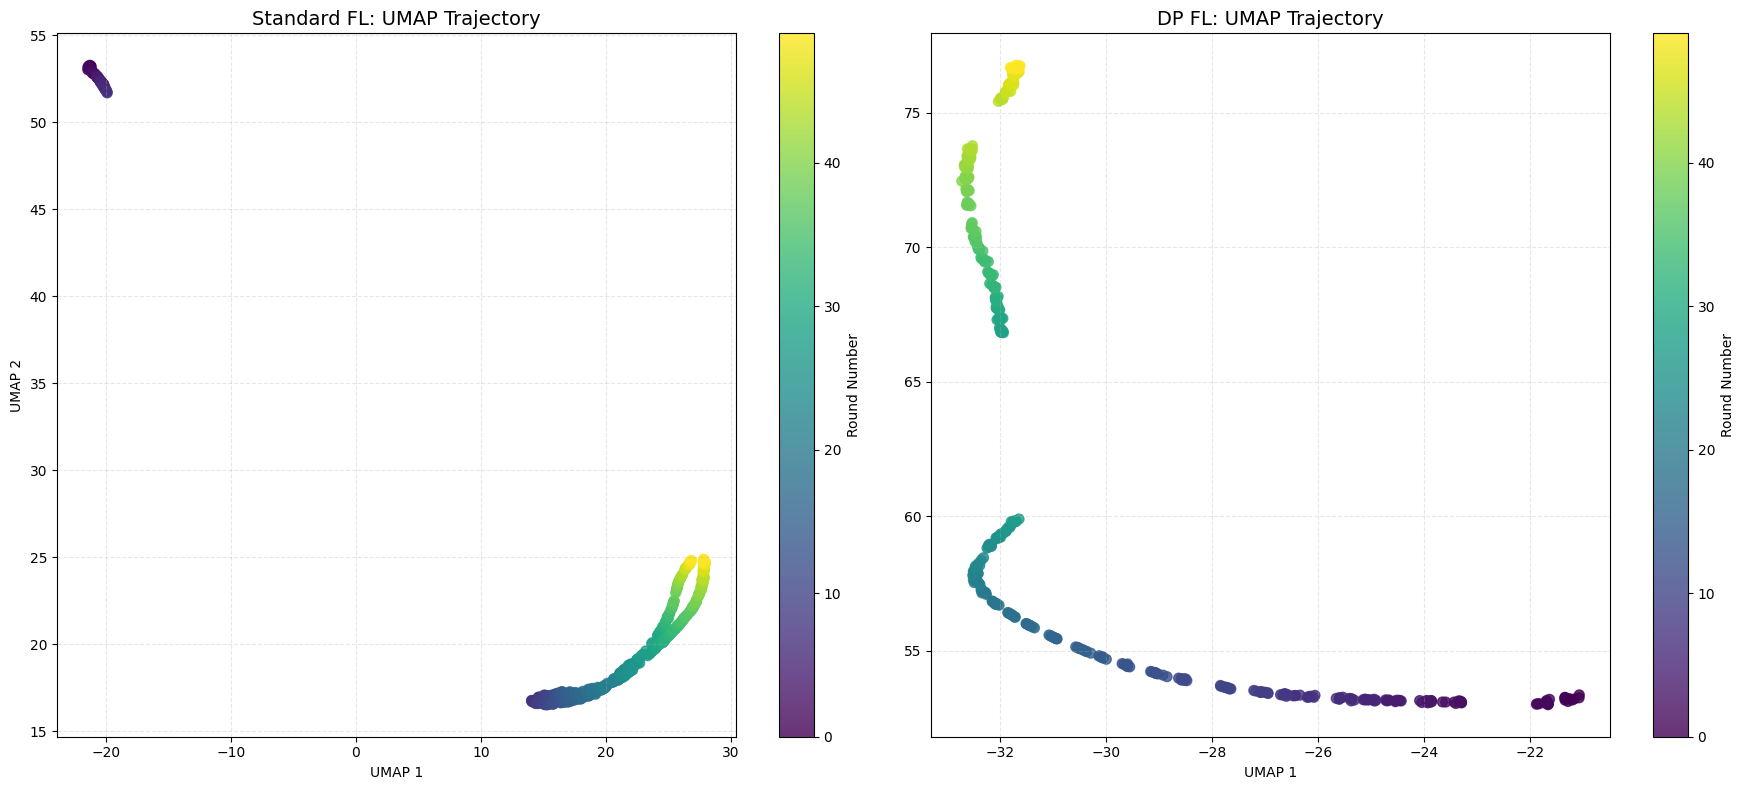

In [1]:
import torch
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import umap

# --- CONFIGURATION ---
DP_BASE_PATH = "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/dp_fl_sens18.0_eps100.0/weights"
FL_BASE_PATH = "/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/fl_run/weights"

# Increase this to see the full long-term trajectory
MAX_ROUNDS_TO_LOAD = 50

# UMAP Settings for Trajectory
# n_neighbors: Higher values (e.g. 30-50) preserve more global structure (better for trajectories)
# min_dist: Controls how tightly points pack together
UMAP_NEIGHBORS = 30
UMAP_MIN_DIST = 0.1

def get_round_num(folder_path):
    folder_name = os.path.basename(folder_path)
    match = re.search(r'round_(\d+)', folder_name)
    if match:
        return int(match.group(1))
    return 0

def load_weights_with_rounds(base_path, max_rounds):
    vectors = []
    round_nums = []
    
    round_dirs = glob.glob(os.path.join(base_path, "round_*"))
    round_dirs.sort(key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isdigit() else 0)
    round_dirs = round_dirs[:max_rounds]
    
    print(f"Loading {len(round_dirs)} rounds from: {os.path.basename(base_path)}...")

    for r_dir in round_dirs:
        current_round = get_round_num(r_dir)
        pt_files = glob.glob(os.path.join(r_dir, "*.pt"))
        
        for pt_file in pt_files:
            if "Global_Model" in pt_file:
                continue
                
            try:
                state_dict = torch.load(pt_file, map_location='cpu')
                if not isinstance(state_dict, dict) and hasattr(state_dict, 'state_dict'):
                    state_dict = state_dict.state_dict()
                
                # Flatten
                keys = sorted(state_dict.keys())
                flat_vector = np.concatenate([state_dict[k].numpy().flatten() for k in keys if hasattr(state_dict[k], 'numpy')])
                
                vectors.append(flat_vector)
                round_nums.append(current_round)
            except Exception as e:
                pass

    return np.array(vectors), np.array(round_nums)

# --- MAIN EXECUTION ---

print("--- Loading Standard FL Data ---")
X_fl, rounds_fl = load_weights_with_rounds(FL_BASE_PATH, MAX_ROUNDS_TO_LOAD)

print("\n--- Loading DP FL Data ---")
X_dp, rounds_dp = load_weights_with_rounds(DP_BASE_PATH, MAX_ROUNDS_TO_LOAD)

if len(X_fl) == 0 or len(X_dp) == 0:
    print("Error: Not enough data found.")
    exit()

# 2. RUNNING UMAP
print("\nRunning UMAP on combined trajectory data...")
combined_X = np.vstack([X_fl, X_dp])

reducer = umap.UMAP(
    n_neighbors=UMAP_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    n_components=2,
    random_state=42
)
combined_embedding = reducer.fit_transform(combined_X)

X_fl_umap = combined_embedding[:len(X_fl)]
X_dp_umap = combined_embedding[len(X_fl):]

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
cmap = 'viridis' # Purple (start) -> Yellow (end)

# --- Plot 1: Standard FL Trajectory ---
sc1 = axes[0].scatter(X_fl_umap[:, 0], X_fl_umap[:, 1], c=rounds_fl, cmap=cmap, s=50, alpha=0.8)
axes[0].set_title("Standard FL: UMAP Trajectory", fontsize=14)
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
axes[0].grid(True, linestyle='--', alpha=0.3)
fig.colorbar(sc1, ax=axes[0], label='Round Number')

# --- Plot 2: DP FL Trajectory ---
sc2 = axes[1].scatter(X_dp_umap[:, 0], X_dp_umap[:, 1], c=rounds_dp, cmap=cmap, s=50, alpha=0.8)
axes[1].set_title("DP FL: UMAP Trajectory", fontsize=14)
axes[1].set_xlabel("UMAP 1")
axes[1].grid(True, linestyle='--', alpha=0.3)
fig.colorbar(sc2, ax=axes[1], label='Round Number')

plt.tight_layout()
output_filename = "fl_vs_dp_umap_rounds.png"
plt.savefig(output_filename)
print(f"\nSaved UMAP trajectory plot to {output_filename}")
plt.show()

IndexError: list index out of range

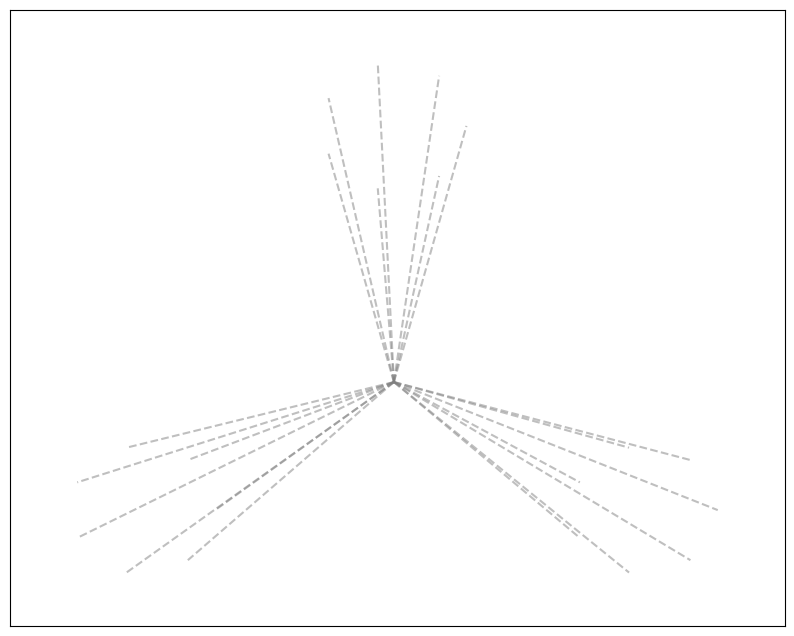

# Generate UMAP plot

## Classification

In [58]:
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [59]:
def plot_umap_weights(data, directory, output_filename="umap_weights.png", title="FRL"):
    print(f"\nGenerating UMAP plot and Metrics for {title}...")

    weights = data['weights']
    labels = data['weight_labels']
    steps = data['weight_steps']

    if len(weights) == 0:
        print("No data found to plot.")
        return

    # 1. Run UMAP Globally
    print("Running UMAP dimensionality reduction...")
    reducer = umap.UMAP(n_components=2, verbose=False, random_state=42)
    umap_results = reducer.fit_transform(weights)

    # --- NEW: QUANTITATIVE METRICS ---
    # Convert filenames to Client Types (labels for our metrics)
    client_types = np.array([get_client_type(l) for l in labels])
    
    # A. Calculate Silhouette Score (Distance Separation)
    # We use umap_results to measure separation in the PLOT space. 
    # (You could also use 'weights' to measure separation in high-dim space)
    try:
        sil_score = silhouette_score(umap_results, client_types)
        print(f"[{title}] Silhouette Score: {sil_score:.4f} (Higher = More Separated)")
    except Exception as e:
        print(f"Could not calc silhouette: {e}")

    # B. Calculate Identifiability (Can we guess the client?)
    # Split data to train a simple classifier
    X_train, X_test, y_train, y_test = train_test_split(umap_results, client_types, test_size=0.3, random_state=42)
    
    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"[{title}] Client Identification Accuracy: {acc:.2%} (Lower = Better Privacy)")
    # ---------------------------------

    # 2. Setup Markers (Existing plotting code continues below...)
    all_types = [get_client_type(l) for l in labels]
    unique_types = sorted(list(set(all_types)))
    
    markers_list = ['o', 's', '^', 'D', 'X', 'P', '*']
    type_to_marker = {t: markers_list[i % len(markers_list)] for i, t in enumerate(unique_types)}

    # 3. Plotting
    plt.figure(figsize=(8, 6))

    # Sort by time
    sort_idx = np.argsort(steps)
    umap_results_sorted = umap_results[sort_idx]
    labels_sorted = labels[sort_idx]
    steps_sorted = steps[sort_idx]
    sorted_types = [get_client_type(l) for l in labels_sorted]
    
    sc = None
    
    for t in unique_types:
        indices = [i for i, x in enumerate(sorted_types) if x == t]
        if not indices: continue
        
        type_umap = umap_results_sorted[indices]
        type_steps = steps_sorted[indices]
        marker = type_to_marker[t]

        sc = plt.scatter(
            type_umap[:, 0],
            type_umap[:, 1],
            c=type_steps,
            cmap='plasma',
            marker=marker,
            alpha=0.7,      
            s=80,
            edgecolors='k',
            linewidth=0.3,
            vmin=np.min(steps),
            vmax=np.max(steps),
            label=f"Type: {t}"
        )

    # Add the metrics to the plot title or caption for the "Proof"
    final_title = (f'{title}: UMAP Trajectory\n'
                 f'K-Means Identifiability: {acc:.0%}')
    plt.title(final_title)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')

    # Legend and Save
    handles = []
    legend_labels = []
    for t in unique_types:
        h = plt.Line2D([0], [0], marker=type_to_marker[t], color='w',
                       markerfacecolor='grey', markeredgecolor='black', 
                       markersize=10)
        handles.append(h)
        legend_labels.append(t)

    plt.legend(handles, legend_labels, title='Client Type', loc='upper left')

    if sc:
        cbar = plt.colorbar(sc)
        cbar.set_label('Round Number (Yellow = Newest)')

    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    os.makedirs(directory, exist_ok=True)
    out_path = os.path.join(directory, output_filename)
    plt.savefig(out_path, dpi=150)
    print(f"Saved '{out_path}'")

--- Processing Standard FL (No DP) ---
Scanning /Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/fl_run/weights...
Loaded 1250 weight vectors.

Generating UMAP plot and Metrics for Standard FL...
Running UMAP dimensionality reduction...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[Standard FL] Silhouette Score: -0.0134 (Higher = More Separated)
[Standard FL] Client Identification Accuracy: 66.67% (Lower = Better Privacy)
Saved 'figures/fl_trajectory.pdf'

Done! Check the 'umap_plots' folder.


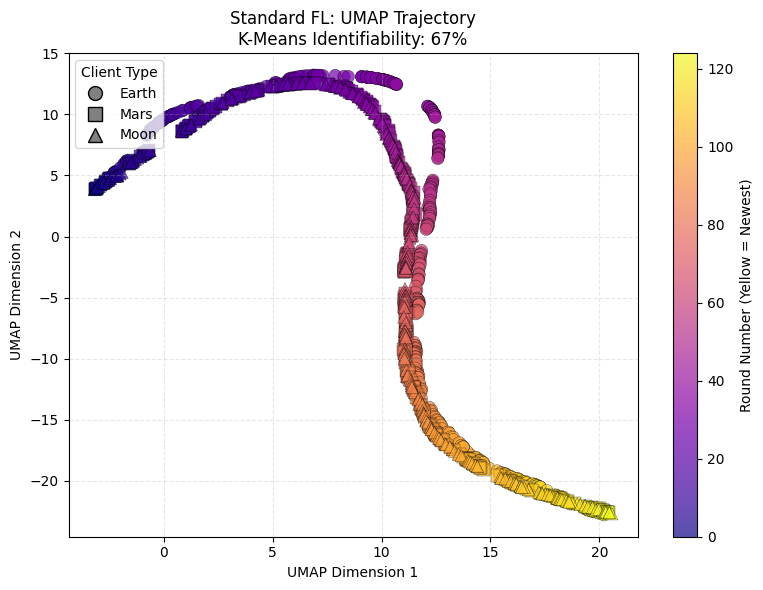

In [53]:
# --- MAIN EXECUTION ---
MAX_ROUNDS = None
# 1. Process Standard FL
print("--- Processing Standard FL (No DP) ---")
fl_data = load_data_recursively(FL_PATH, MAX_ROUNDS)
if len(fl_data['weights']) > 0:
    plot_umap_weights(fl_data, OUTPUT_DIR, output_filename="fl_trajectory.pdf", title="Standard FL")

# 2. Process DP FL

    

print("\nDone! Check the 'umap_plots' folder.")


--- Processing DP 1000 FL ---
Scanning /Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/dp_fl_sens18.0_eps1000.0/weights...
Loaded 1250 weight vectors.

Generating UMAP plot and Metrics for Differentially Private FL EPS=1000...
Running UMAP dimensionality reduction...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[Differentially Private FL EPS=1000] Silhouette Score: -0.0146 (Higher = More Separated)
[Differentially Private FL EPS=1000] Client Identification Accuracy: 65.87% (Lower = Better Privacy)
Saved 'figures/dp_1000trajectory.pdf'


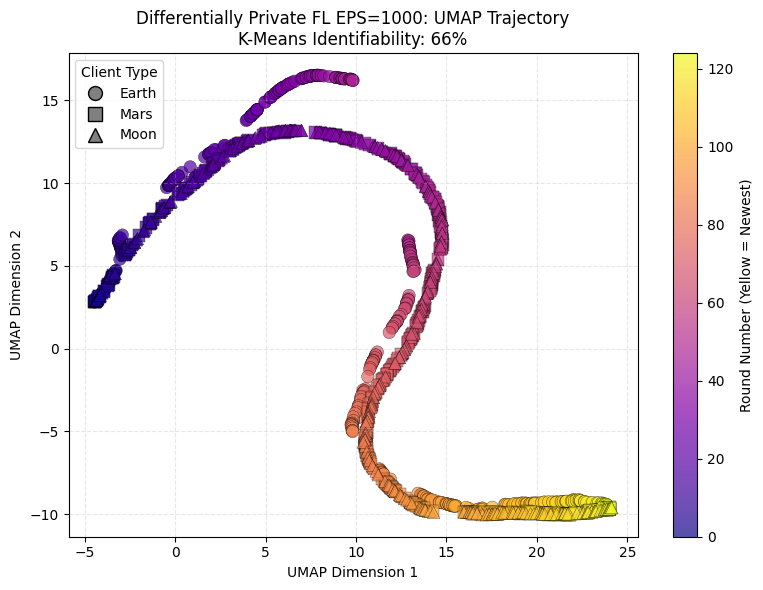

In [54]:
print("\n--- Processing DP 1000 FL ---")
dp_data = load_data_recursively(DP1000_PATH, MAX_ROUNDS)
if len(dp_data['weights']) > 0:
    plot_umap_weights(dp_data, OUTPUT_DIR, output_filename="dp_1000trajectory.pdf", title="Differentially Private FL EPS=1000")




--- Processing D 100 FL ---
Scanning /Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/dp_fl_sens18.0_eps100.0/weights...
Loaded 1250 weight vectors.

Generating UMAP plot and Metrics for Differentially Private FL EPS=100...
Running UMAP dimensionality reduction...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[Differentially Private FL EPS=100] Silhouette Score: -0.0076 (Higher = More Separated)
[Differentially Private FL EPS=100] Client Identification Accuracy: 28.27% (Lower = Better Privacy)
Saved 'figures/dp_100trajectory.pdf'


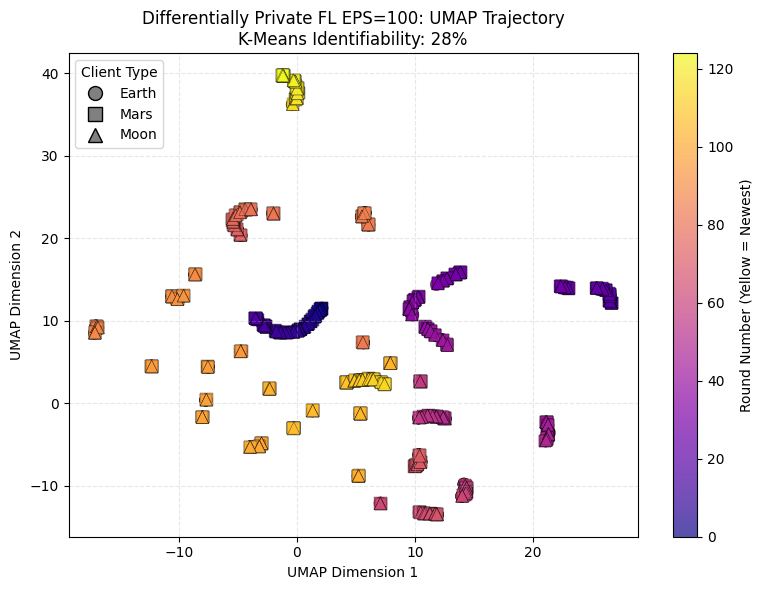

In [55]:
print("\n--- Processing D 100 FL ---")
dp_data = load_data_recursively(DP100_PATH, MAX_ROUNDS)
if len(dp_data['weights']) > 0:
    plot_umap_weights(dp_data, OUTPUT_DIR, output_filename="dp_100trajectory.pdf", title="Differentially Private FL EPS=100")




--- Processing D 500 FL ---
Scanning /Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/dp_fl_sens18.0_eps500.0/weights...
Loaded 1250 weight vectors.

Generating UMAP plot and Metrics for Differentially Private FL EPS= 500...
Running UMAP dimensionality reduction...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[Differentially Private FL EPS= 500] Silhouette Score: -0.0088 (Higher = More Separated)
[Differentially Private FL EPS= 500] Client Identification Accuracy: 46.67% (Lower = Better Privacy)
Saved 'figures/dp_500trajectory.pdf'


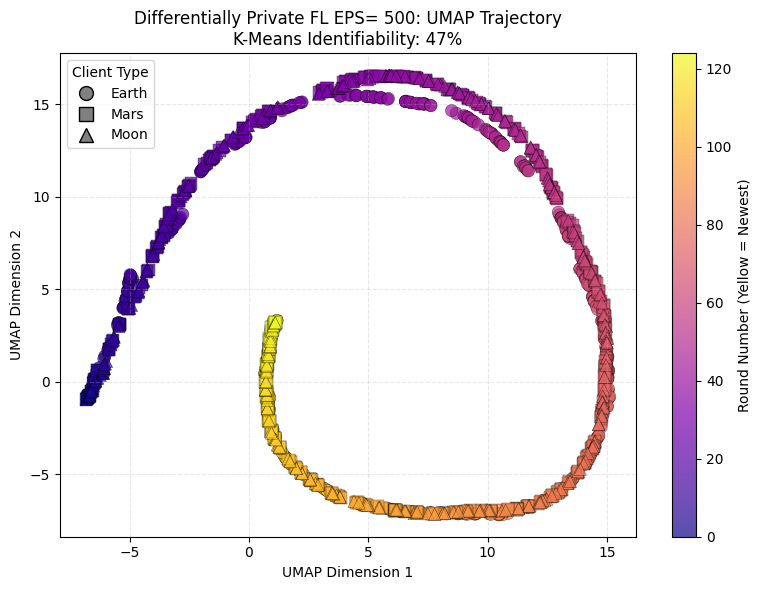

In [56]:
print("\n--- Processing D 500 FL ---")
dp_data = load_data_recursively(DP500_PATH, MAX_ROUNDS)
if len(dp_data['weights']) > 0:
    plot_umap_weights(dp_data, OUTPUT_DIR, output_filename="dp_500trajectory.pdf", title="Differentially Private FL EPS= 500")




--- Processing D 5000 FL ---
Scanning /Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/dp_fl_sens18.0_eps5000/weights...
Loaded 1250 weight vectors.

Generating UMAP plot and Metrics for Differentially Private FL EPS=5000...
Running UMAP dimensionality reduction...


/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/rlproject/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[Differentially Private FL EPS=5000] Silhouette Score: -0.0114 (Higher = More Separated)
[Differentially Private FL EPS=5000] Client Identification Accuracy: 58.67% (Lower = Better Privacy)
Saved 'figures/dp_5000trajectory.pdf'


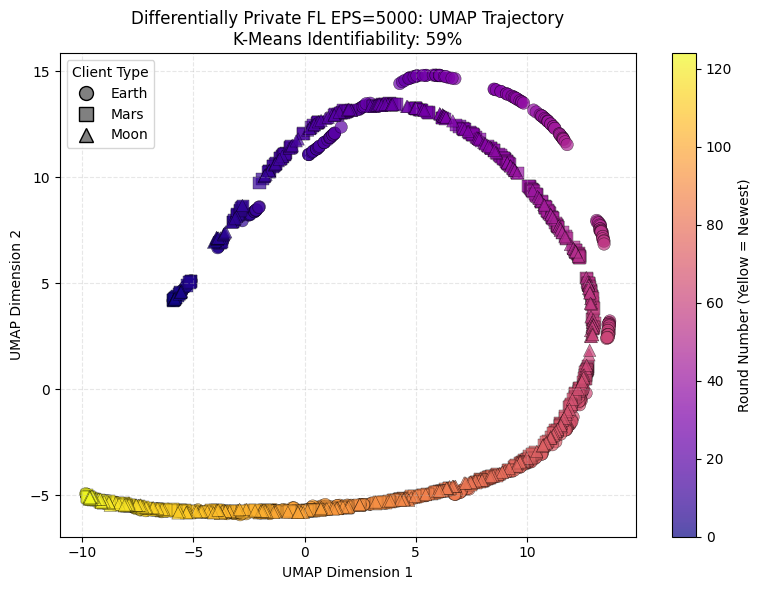

In [57]:
print("\n--- Processing D 5000 FL ---")
dp_data = load_data_recursively(DP5000_PATH, MAX_ROUNDS)
if len(dp_data['weights']) > 0:
    plot_umap_weights(dp_data, OUTPUT_DIR, output_filename="dp_5000trajectory.pdf", title="Differentially Private FL EPS=5000")

# Generate gif of agent

In [50]:
import imageio
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Define your environment arguments here
env_kwargs = {
    "enable_wind": True,
    "wind_power": 6.0,       # Recommended between 0.0 and 20.0
    "enable_wind": True,
    "gravity": -9.8
}

# Pass the dictionary to make_vec_env
env = make_vec_env("LunarLander-v3", n_envs=1, env_kwargs=env_kwargs)

model = PPO.load("/Users/henriquerio/Documents/IIT/CS595-Project-FedRL/sv_results/v4/logs/fl_run/global_fl_model_final.zip", env=env)

images = []
obs = env.reset()
img = env.render(mode="rgb_array")

for i in range(2000):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _, _ = env.step(action)
    img = env.render(mode="rgb_array")

imageio.mimsave("lander_windy.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

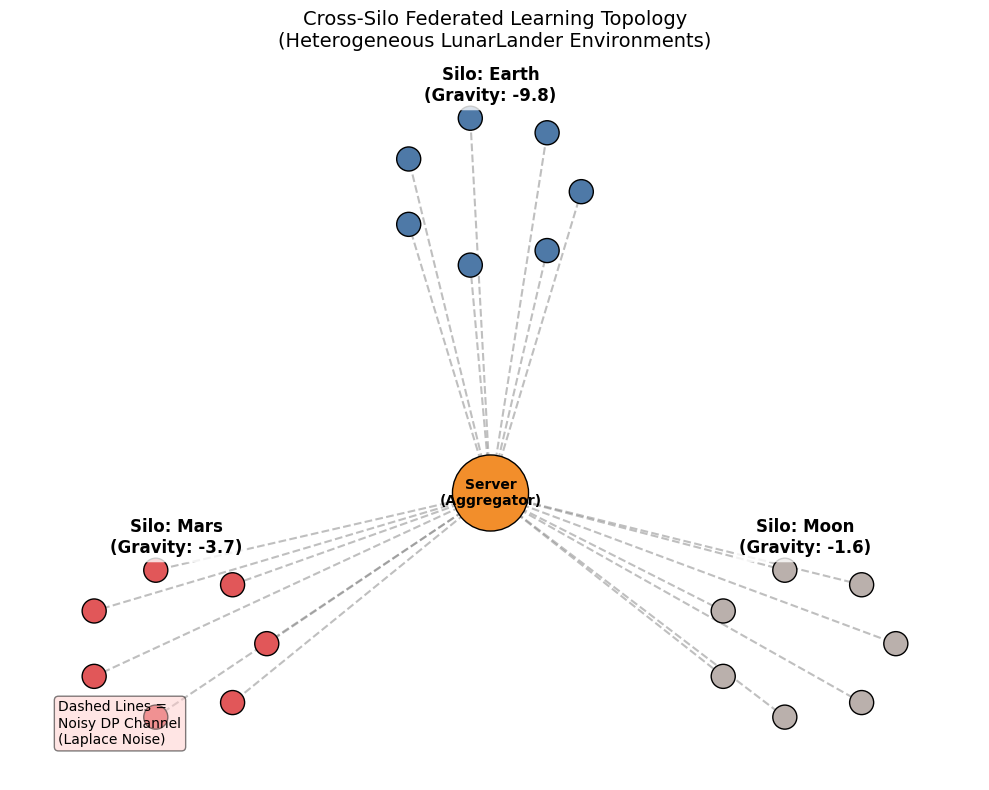

In [38]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def draw_silo_federation():
    G = nx.Graph()
    
    # --- Configuration ---
    # Silo Definitions (Gravity serves as the heterogeneous attribute)
    silos = {
        "Earth": {"color": "#4e79a7", "gravity": "-9.8", "count": 7, "angle": 90},  # Blue
        "Mars":  {"color": "#e15759", "gravity": "-3.7", "count": 7, "angle": 210}, # Red
        "Moon":  {"color": "#bab0ac", "gravity": "-1.6", "count": 7, "angle": 330}  # Grey
    }

    pos = {}
    
    # 1. Add Central Server
    G.add_node("Server", color="#f28e2b", size=3000, label="Server\n(Aggregator)") # Gold/Orange
    pos["Server"] = (0, 0)
    
    # --- Generate Silos ---
    silo_dist = 2.0      # Radius for the silos from the center
    client_spread = 0.5  # Radius for clients within a silo

    for planet, data in silos.items():
        # Calculate center of the planet cluster
        rad_angle = np.radians(data["angle"])
        center_x = silo_dist * np.cos(rad_angle)
        center_y = silo_dist * np.sin(rad_angle)
        
        # Add a label node (invisible node just for positioning text later)
        label_node = f"Label_{planet}"
        G.add_node(label_node, color="none", size=0, label="") # Invisible attributes
        pos[label_node] = (center_x, center_y + 0.6)
        
        # Create Clients
        for i in range(1, data["count"] + 1):
            client_name = f"{planet}_{i}"
            
            # Add Client Node with attributes
            G.add_node(client_name, color=data["color"], size=300, label="")
            G.add_edge("Server", client_name)
            
            # Position clients in a small circle around the planet center
            client_angle = np.radians((360 / data["count"]) * i)
            c_x = center_x + client_spread * np.cos(client_angle)
            c_y = center_y + client_spread * np.sin(client_angle)
            pos[client_name] = (c_x, c_y)
            
    # --- Plotting ---
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    
    # Filter nodes to draw (Excluding "Label_" nodes)
    draw_nodes = [n for n in G.nodes if not n.startswith("Label")]
    
    # Extract attributes specifically for the nodes we are drawing
    draw_colors = [G.nodes[n]['color'] for n in draw_nodes]
    draw_sizes  = [G.nodes[n]['size'] for n in draw_nodes]
    
    # 1. Draw Edges (Communication Channels)
    nx.draw_networkx_edges(G, pos, edge_color='gray', style='dashed', alpha=0.5, width=1.5)
    
    # 2. Draw Nodes
    nx.draw_networkx_nodes(G, pos, nodelist=draw_nodes, node_color=draw_colors, node_size=draw_sizes, edgecolors='black')
    
    # 3. Draw Server Label (Only label the Server node)
    server_labels = {n: G.nodes[n]['label'] for n in draw_nodes if n == "Server"}
    nx.draw_networkx_labels(G, pos, labels=server_labels, font_size=10, font_weight="bold")

    # 4. Annotate the Silos (Planets)
    for planet, data in silos.items():
        # Retrieve the position of our invisible label node
        label_pos = pos[f"Label_{planet}"]
        
        plt.text(label_pos[0], label_pos[1], 
                 f"Silo: {planet}\n(Gravity: {data['gravity']})", 
                 fontsize=12, fontweight='bold', ha='center', 
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

    # 5. Add "DP Barrier" annotation
    plt.text(0.05, 0.05, "Dashed Lines =\nNoisy DP Channel\n(Laplace Noise)", 
             fontsize=10, ha='left', transform=ax.transAxes,
             bbox=dict(facecolor='#ffcccb', alpha=0.5, boxstyle='round'))

    plt.title("Cross-Silo Federated Learning Topology\n(Heterogeneous LunarLander Environments)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    draw_silo_federation()